In [10]:
import thermo as th
import thermo.interaction_parameters as ip
import numpy as np
import pandas as pd

In [11]:
def create_VL_flasher(names: list) -> th.flash.FlashVL:
    # Look up chemical constants/properties from database
    constants, properties = th.ChemicalConstantsPackage.from_IDs(names)

    # Look up binary interaction parameters from database
    kijs = ip.IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

    eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs,
                  'omegas': constants.omegas, 'kijs': kijs}

    # Create individual gas and liquid phase EOSs
    gas = th.CEOSGas(th.PRMIX, eos_kwargs,
                     HeatCapacityGases=properties.HeatCapacityGases)
    liquid = th.CEOSLiquid(th.PRMIX, eos_kwargs,
                           HeatCapacityGases=properties.HeatCapacityGases)

    # Create VL flasher
    return th.FlashVL(constants, properties, liquid=liquid, gas=gas)

In [12]:
flasher = create_VL_flasher(['methane', 'ethane', 'propane'])

In [13]:
P_rel = 1e6 #Pa
zs = [0.1, 0.4, 0.5]
num_points = 25

In [14]:
data = pd.DataFrame(np.linspace(flasher.flash(P=P_rel, VF=0, zs=zs).T,
                                flasher.flash(P=P_rel, VF=1, zs=zs).T,
                                num_points), 
                    columns=['T (K)'])

In [15]:
@np.vectorize
def find_props(T):
    state = flasher.flash(P=P_rel, T=T, zs=zs)
    return state.VF, state.H()

In [24]:
data['VF (molar)'], data['H (J/mol)'] = find_props(data['T (K)'])
data['H_Added (J/mol)'] = data['H (J/mol)'] - data['H (J/mol)'][0]
data.head()

,T (K),VF (molar),H (J/mol),H_Added (J/mol)
0,221.092445,1.691927e-11,-19875.165253,0.000000
1,223.480092,1.040005e-02,-19595.269669,279.895584
2,225.867740,2.108049e-02,-19308.578729,566.586525
3,228.255387,3.219052e-02,-19013.380142,861.785111
4,230.643035,4.389804e-02,-18707.690524,1167.474730


<AxesSubplot:xlabel='VF (molar)'>

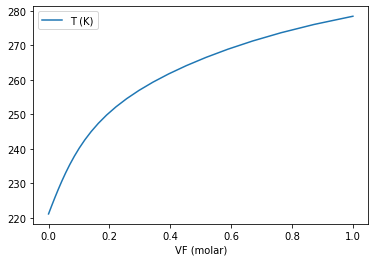

In [17]:
data.plot(x='VF (molar)', y='T (K)')

<AxesSubplot:xlabel='VF (molar)'>

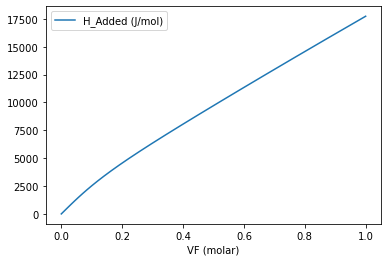

In [23]:
data.plot(x='VF (molar)', y='H_Added (J/mol)')

<AxesSubplot:xlabel='VF (molar)'>

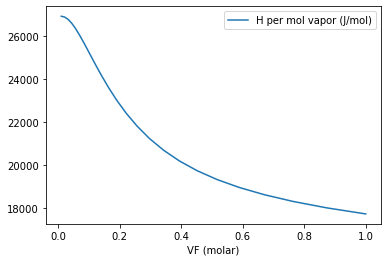

In [28]:
data['H per mol vapor (J/mol)'] = data['H_Added (J/mol)'] / data['VF (molar)']
data[1:].plot(x='VF (molar)', y='H per mol vapor (J/mol)')

In [29]:
timeit(find_props(data['T (K)']))

67.9 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
